In [2]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             RocCurveDisplay, PrecisionRecallDisplay)


In [3]:
#Use the Storm Prediction Center tornado dataset https://www.spc.noaa.gov/wcm/data/1950-2021_actual_tornadoes.csv

#Also, use the ENSO, PDO, NAO, and AO dataframe from earlier module.

#Reading the tornado dataset
tornadoes = pd.read_csv('https://www.spc.noaa.gov/wcm/data/1950-2021_actual_tornadoes.csv')

#Reading and processing the ENSO dataset

#enso = pd.read_csv('https://www.atmos.illinois.edu/~snesbitt/soi.dat',sep=r'\s+',header=None,skiprows=4,skipfooter=0, engine='python')
pdo = pd.read_csv('https://www.ncei.noaa.gov/pub/data/cmb/ersst/v5/index/ersst.v5.pdo.dat',sep=r'\s+',header=None,skiprows=2, engine='python')
nao = pd.read_csv('https://www.cpc.ncep.noaa.gov/products/precip/CWlink/pna/norm.nao.monthly.b5001.current.ascii.table',sep=r'\s+',header=None,skiprows=1, engine='python')
ao = pd.read_csv('https://www.cpc.ncep.noaa.gov/products/precip/CWlink/daily_ao_index/monthly.ao.index.b50.current.ascii.table',sep=r'\s+',header=None,skiprows=1, engine='python')

In [4]:
# I had problems downloading the enso data as in the code provided by the professor. I gor error 503 like the server was down. It was also difficult to access NOA data. I found and downloaded el Nino soi data but it is hard to corroborate if it was the same time series.
enso = pd.read_csv('data/soi_long.csv')

In [5]:
print(enso.head())

       Date  ENSO
0  1/1/1900 -0.89
1  2/1/1900 -0.73
2  3/1/1900 -2.95
3  4/1/1900 -2.10
4  5/1/1900 -0.76


In [6]:
print(tornadoes)

           om    yr  mo  dy        date      time  tz  st  stf  stn  ...  \
0         192  1950  10   1  1950-10-01  21:00:00   3  OK   40   23  ...   
1         193  1950  10   9  1950-10-09  02:15:00   3  NC   37    9  ...   
2         195  1950  11  20  1950-11-20  02:20:00   3  KY   21    1  ...   
3         196  1950  11  20  1950-11-20  04:00:00   3  KY   21    2  ...   
4         197  1950  11  20  1950-11-20  07:30:00   3  MS   28   14  ...   
...       ...   ...  ..  ..         ...       ...  ..  ..  ...  ...  ...   
67553  620523  2021   9   8  2021-09-08  15:32:00   3  PA   42    0  ...   
67554  620524  2021   9   8  2021-09-08  15:35:00   3  PA   42    0  ...   
67555  620525  2021   9   8  2021-09-08  19:08:00   3  FL   12    0  ...   
67556  620526  2021   9   9  2021-09-09  02:10:00   3  CT    9    0  ...   
67557  620527  2021   9   9  2021-09-09  17:58:00   3  CA    6    0  ...   

         len  wid  ns  sn  sg   f1  f2  f3  f4  fc  
0      15.80   10   1   1   1   25

In [7]:
# 1. Aggregate the tornado data over the following states into a monthly count of tornadoes:

 #  - Illinois

#Filter for Illinois
il_tornadoes = tornadoes[tornadoes['st'] == 'IL']


#Group by year and month, count tornadoes
monthly_counts = (
    il_tornadoes
    .groupby(['yr', 'mo'])
    .size()
    .reset_index(name='tornado_count')
)

print(monthly_counts)

       yr  mo  tornado_count
0    1950   1              2
1    1950   3              1
2    1950   6              1
3    1950   7              1
4    1950  12              3
..    ...  ..            ...
440  2021   6             15
441  2021   7              8
442  2021   8             16
443  2021  10             10
444  2021  12              8

[445 rows x 3 columns]


In [8]:
# Merge this monthly tornado dataset with the ENSO, PDO, NAO, and AO dataframe created in Module 4 Notebook 1

#First formating the climatological datasets to have year and month columns for merging.

In [9]:

# Filter for the desired date range
enso['Date'] = pd.to_datetime(enso['Date'])
enso_new = enso[(enso['Date'].dt.year >= 1951) & (enso['Date'].dt.year <= 2025)]

enso_new = enso_new.set_index('Date')

print(enso_new.head())

            ENSO
Date            
1951-01-01  1.32
1951-02-01  0.47
1951-03-01 -0.71
1951-04-01 -1.03
1951-05-01 -1.29


In [10]:
nao_new=pd.DataFrame()
pdo_new=pd.DataFrame()
ao_new=pd.DataFrame()

nao_new['Date'] = pd.date_range(start=datetime.datetime(nao[0].iloc[0],1,1),end=datetime.datetime(nao[0].iloc[-1],12,1),freq="MS")
pdo_new['Date'] = pd.date_range(start=datetime.datetime(pdo[0].iloc[0],1,1),end=datetime.datetime(pdo[0].iloc[-1],12,1),freq="MS")
ao_new['Date'] = pd.date_range(start=datetime.datetime(ao[0].iloc[0],1,1),end=datetime.datetime(ao[0].iloc[-1],12,1),freq="MS")

nao_new = nao_new.set_index('Date')
pdo_new = pdo_new.set_index('Date')
ao_new = ao_new.set_index('Date')

nao_new['NAO']=nao.loc[:,1:].stack(dropna=False).values
pdo_new['PDO']=pdo.loc[:,1:].stack(dropna=False).values
ao_new['AO']=ao.loc[:,1:].stack(dropna=False).values

C:\Users\jclabarcena\AppData\Local\Temp\ipykernel_34808\1740848809.py:13: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  nao_new['NAO']=nao.loc[:,1:].stack(dropna=False).values
C:\Users\jclabarcena\AppData\Local\Temp\ipykernel_34808\1740848809.py:14: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  pdo_new['PDO']=pdo.loc[:,1:].stack(dropna=False).values
C:\Users\jclabarcena\AppData\Local\Temp\ipykernel_34808\1740848809.py:15: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pand

In [11]:
#Filtering dates to match ENSO dataset
nao_new = nao_new[
    (nao_new.index.year >= 1951) ]

pdo_new = pdo_new[
    (pdo_new.index.year >= 1951) ]

ao_new= ao_new[
    (ao_new.index.year >= 1951) ]

In [12]:
newdf_all = pd.merge(enso_new,pdo_new, left_index=True, right_index=True)

In [13]:
print(newdf_all.tail())

              ENSO    PDO
Date                     
2025-08-01 -9999.0  -3.19
2025-09-01 -9999.0  -2.31
2025-10-01 -9999.0  -2.36
2025-11-01 -9999.0  -1.67
2025-12-01 -9999.0  99.99


In [14]:
#Fixing the missing values
newdf_all.loc[newdf_all['PDO'] > 90.,'PDO'] = np.nan

In [15]:
newdf_all.loc[newdf_all['ENSO'] <= -9999.0,'ENSO'] = np.nan

In [16]:
newdf_all = pd.merge(newdf_all,nao_new, left_index=True, right_index=True)
newdf_all.loc[newdf_all['NAO'] <= -99.9,'NAO'] = np.nan

<Axes: xlabel='Date'>

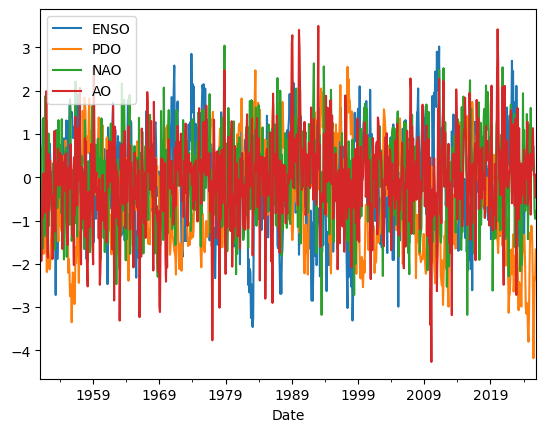

In [17]:
newdf_all = pd.merge(newdf_all,ao_new, left_index=True, right_index=True)
newdf_all.loc[newdf_all['AO'] <= -99.9,'AO'] = np.nan

newdf_all.plot()

In [18]:
print(newdf_all.tail())

            ENSO   PDO   NAO     AO
Date                               
2025-08-01   NaN -3.19  0.26  0.036
2025-09-01   NaN -2.31 -0.80  0.048
2025-10-01   NaN -2.36 -0.96  0.064
2025-11-01   NaN -1.67 -0.78 -0.467
2025-12-01   NaN   NaN   NaN    NaN


In [19]:
#Merging the tornado monthly counts with the climate indices dataframe.
monthly_counts["Date"] = pd.to_datetime(
    dict(year=monthly_counts["yr"], month=monthly_counts["mo"], day=1))

monthly_counts = monthly_counts.set_index("Date").sort_index()

monthly_counts = monthly_counts[monthly_counts.index.year >= 1951]

merged = monthly_counts.join(newdf_all, how="left")

print(merged.head())
print(merged.tail())
print(merged.tail())

              yr  mo  tornado_count  ENSO   PDO   NAO     AO
Date                                                        
1951-06-01  1951   6              2 -0.52 -1.77 -1.64 -0.918
1951-11-01  1951  11              2 -0.98 -0.31 -0.39 -0.069
1951-12-01  1951  12              1 -0.90 -1.45  1.32  1.987
1952-03-01  1952   3              2 -0.02 -1.67 -1.49 -1.859
1952-05-01  1952   5              1  0.67 -2.07 -1.12 -0.774
              yr  mo  tornado_count  ENSO   PDO   NAO     AO
Date                                                        
2021-06-01  2021   6             15  0.22 -1.82  0.77  0.845
2021-07-01  2021   7              8  1.61 -2.00  0.03  0.630
2021-08-01  2021   8             16  0.27 -0.95 -0.28 -0.209
2021-10-01  2021  10             10  0.51 -3.13 -2.29 -0.146
2021-12-01  2021  12              8  1.43 -2.71  0.29  0.198
              yr  mo  tornado_count  ENSO   PDO   NAO     AO
Date                                                        
2021-06-01  2021   6    

In [20]:
#All good to go with the model
#Create a random forest regression model and use features that include the 4 climate indices to predict the monthly number of tornadoes.  Create a scatter plot of the predicted and observed number of tornadoes over these states.  Report the correlation coefficient and RMSE of your model.

In [21]:
# if tornado_count isn't already there, adjust this column name accordingly
target_col = "tornado_count"
feature_cols = ["ENSO", "PDO", "NAO", "AO"]

# drop rows where either target or any feature is missing
data_model = merged.dropna(subset=[target_col] + feature_cols)

print(data_model.head())
print(data_model[feature_cols].isna().sum())

              yr  mo  tornado_count  ENSO   PDO   NAO     AO
Date                                                        
1951-06-01  1951   6              2 -0.52 -1.77 -1.64 -0.918
1951-11-01  1951  11              2 -0.98 -0.31 -0.39 -0.069
1951-12-01  1951  12              1 -0.90 -1.45  1.32  1.987
1952-03-01  1952   3              2 -0.02 -1.67 -1.49 -1.859
1952-05-01  1952   5              1  0.67 -2.07 -1.12 -0.774
ENSO    0
PDO     0
NAO     0
AO      0
dtype: int64


In [22]:
#For time series with Random Forest, you must split chronologically (past for training, future for testing) to prevent data leakage
data_model = data_model.sort_index()

X = data_model.drop(["yr", "mo", "tornado_count"], axis=1).values
y = data_model["tornado_count"].values

n = len(data_model)          # 440
split_idx = int(n * 0.8)     # 80% train, 20% test

X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(X_train.shape, X_test.shape)

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

forest = RandomForestRegressor(
    n_estimators=300,
    random_state=0,
    n_jobs=-1
)

forest.fit(X_train, y_train)
X_train_preds = forest.predict(X_train)
X_test_preds  = forest.predict(X_test)

(352, 4) (88, 4)


In [23]:
#Meauring model performance
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds)))
print('test rmse: {}'.format(np.sqrt(mean_squared_error(y_test, X_test_preds))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds)))

test mse: 58.92390732323233
test rmse: 7.676190938429836
test r2: -0.16838752691402536


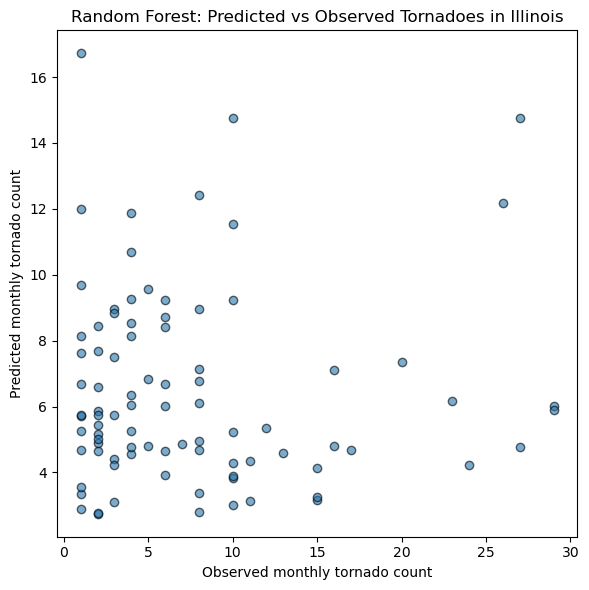

In [24]:
import matplotlib.pyplot as plt

# Scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(y_test, X_test_preds, alpha=0.6, edgecolor="k")

plt.xlabel("Observed monthly tornado count")
plt.ylabel("Predicted monthly tornado count")
plt.title("Random Forest: Predicted vs Observed Tornadoes in Illinois")
plt.tight_layout()
plt.show()

In [25]:
# Create a one-hot encoding for the month of the year.  Repeat the scatterplot and compare the RMSE and correlation coefficient values.

In [26]:
#One-hot encode month
month_dummies = pd.get_dummies(data_model["mo"], prefix="month")

# Add to data_model
data_model_month = pd.concat([data_model, month_dummies], axis=1)

print(data_model_month)

              yr  mo  tornado_count  ENSO   PDO   NAO     AO  month_1  \
Date                                                                    
1951-06-01  1951   6              2 -0.52 -1.77 -1.64 -0.918    False   
1951-11-01  1951  11              2 -0.98 -0.31 -0.39 -0.069    False   
1951-12-01  1951  12              1 -0.90 -1.45  1.32  1.987    False   
1952-03-01  1952   3              2 -0.02 -1.67 -1.49 -1.859    False   
1952-05-01  1952   5              1  0.67 -2.07 -1.12 -0.774    False   
...          ...  ..            ...   ...   ...   ...    ...      ...   
2021-06-01  2021   6             15  0.22 -1.82  0.77  0.845    False   
2021-07-01  2021   7              8  1.61 -2.00  0.03  0.630    False   
2021-08-01  2021   8             16  0.27 -0.95 -0.28 -0.209    False   
2021-10-01  2021  10             10  0.51 -3.13 -2.29 -0.146    False   
2021-12-01  2021  12              8  1.43 -2.71  0.29  0.198    False   

            month_2  month_3  month_4  month_5  mo

In [27]:
#For time series with Random Forest, you must split chronologically (past for training, future for testing) to prevent data leakage
data_model_month = data_model_month.sort_index()

X = data_model_month.drop(["yr", "mo", "tornado_count"], axis=1).values #Considering the 12 months as features
y = data_model_month["tornado_count"].values

n = len(data_model_month)          # 440
split_idx = int(n * 0.8)     # 80% train, 20% test

X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(X_train.shape, X_test.shape)


forest = RandomForestRegressor(
    n_estimators=300,
    random_state=0,
    n_jobs=-1
)

forest.fit(X_train, y_train)
X_train_preds = forest.predict(X_train)
X_test_preds  = forest.predict(X_test)

(352, 16) (88, 16)


In [28]:
#Meauring model performance
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds)))
print('test rmse: {}'.format(np.sqrt(mean_squared_error(y_test, X_test_preds))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds)))


test mse: 45.012589772727274
test rmse: 6.709142253129477
test r2: 0.10745653447498871


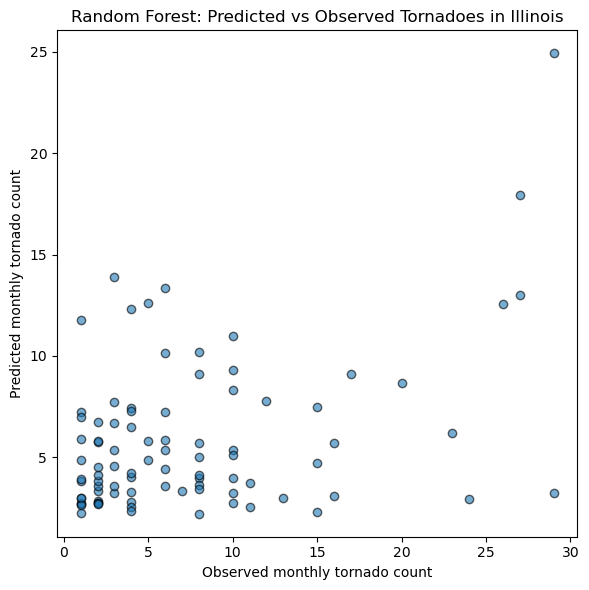

In [29]:
import matplotlib.pyplot as plt

# Scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(y_test, X_test_preds, alpha=0.6, edgecolor="k")

plt.xlabel("Observed monthly tornado count")
plt.ylabel("Predicted monthly tornado count")
plt.title("Random Forest: Predicted vs Observed Tornadoes in Illinois")
plt.tight_layout()
plt.show()

In [30]:
#5. Perform a feature importance and multipass permutation analysis of your features.

Text(0.5, 1.0, 'Random Forest feature importance')

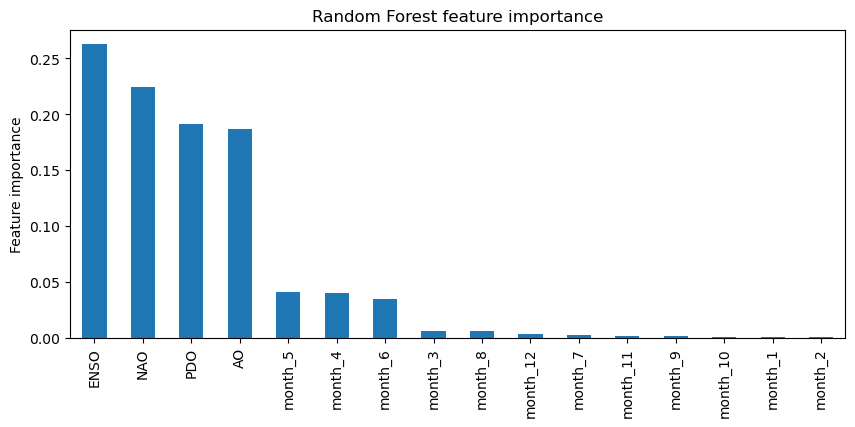

In [31]:
#the importance is given by the absolute value of the coefficient for each feature in the random forest model.
feature_cols = data_model_month.drop(["yr", "mo", "tornado_count"], axis=1).columns
importance = pd.Series(forest.feature_importances_, index=feature_cols)
importance = importance.sort_values(ascending=False)

ax = importance.plot.bar(figsize=(10, 4))
ax.set_ylabel("Feature importance")
ax.set_title("Random Forest feature importance")

In [34]:
#6. Create a SHAP Summary Plot showing feature importance and feature effects.
import shap

c:\Users\jclabarcena\AppData\Local\anaconda3\envs\xarray-climate\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


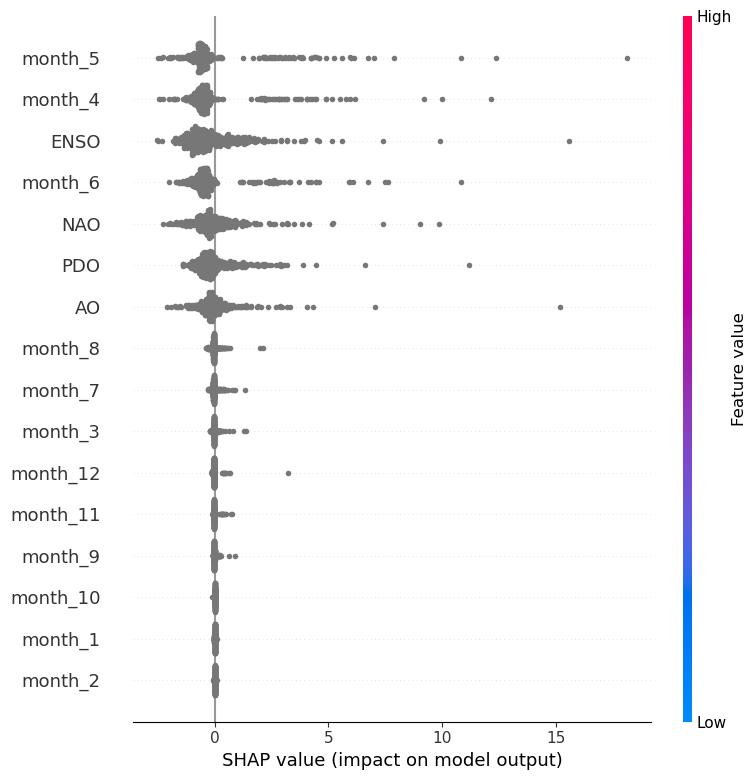

In [40]:
#Use train data for SHAP and creating a dataframe
X_train_df = pd.DataFrame(X_train, columns=feature_cols)

explainer = shap.TreeExplainer(forest)

# You can use all rows, or a sample if it's big
X_shap = X_train_df

shap_values = explainer.shap_values(X_shap)

shap.summary_plot(shap_values, X_train_df, plot_type="dot")


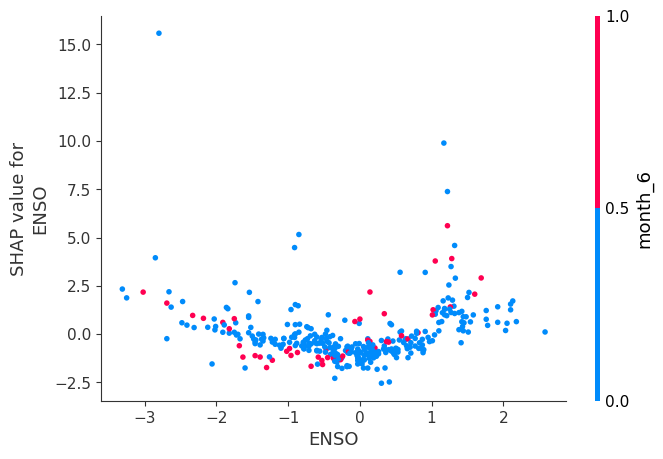

In [41]:
#7. Create a SHAP Feature Dependence for the ENSO index.

shap.initjs()

#SHAP dependence plot for ENSO
shap.dependence_plot("ENSO", shap_values, X_train_df)

8. Any observations on the importance of the various features in your model from the XAI techniques you tried?

By the feauture importance ENSO is the dominant driver, however the SHAP analysis reveals that ENSO is not the dominant driver. Most SHAP values for ENSO are clustered near 0, which means that for typical ENSO values the model only nudges the predicted tornado count a little.The larger SHAP values appear at more extreme ENSO values (strong El Niño / La Niña) – that’s where ENSO starts to have a noticeable effect on the prediction. The shape is non-linear: the effect is small near ENSO ≈ 0 and grows towards the extremes, rather than being a straight line.

This suggests ENSO matters mainly during strong events and there seems to be a seasonality effect in the month of June.
